## Portfolio Assignment week 03

This week's focus is on anomaly detection. As part of the portfolio assignment, you are required to make a contribution using anomaly detection algorithm(s). There are several options for your contribution, so you can choose the one that aligns with your learning style or interests the most

## Anomaly Detection

Anomaly detection in machine learning refers to the process of identifying patterns or instances in a dataset that deviate significantly from the norm or expected behavior. Anomalies, also known as outliers, are data points that are rare, unusual, or don't conform to the typical patterns observed in the majority of the data. Anomaly detection algorithms aim to automatically detect these anomalies. Anomaly detection in machine learning has various applications across domains, including predictive maintenance, and healthcare monitoring. By automatically identifying anomalies, these algorithms help in detecting potential risks. 


## Anomaly Detection Assignment

Study the notebook `Study_Case_Anomoly_Detection` 

Choose at least 1 out of the listed assignments below

- Analyze the end result plot to evaluate the algorithm's performance. Look for anomalies identified by the algorithm and compare them to known anomalies or instances of abnormal behavior in the data. Assess whether the algorithm successfully captures these anomalies and if it shows promising results in detecting abnormal patterns. Based on the plot analysis, provide argumentation for the validity of the anomaly detection algorithm hypothesis (see above). Discuss how the algorithm effectively captures anomalies in the time series data and why it is a suitable approach for the use case. Support your argument with references to relevant literature that discuss the effectiveness of the chosen algorithm or similar algorithms in detecting anomalies in time series data.
- To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook.
- Try another algorithm that has not been tested in the notebook. Provide argumentation for the validity of the anomaly detection algorithm you choose.
- Try to find the best configuration for one of the tested algorithms
- Try anomaly detection on a different dataset without timeseries data. Intrepret the results

Do not forget to reference sources!

---

used as reference material:
https://scikit-learn.org/stable/modules/outlier_detection.html

In [44]:
#Import modules
import pandas as pd
import matplotlib.pyplot as plt
import yaml

In [45]:
# load the data
with open('config.yaml', 'r') as conf:
    config = yaml.load(conf, yaml.SafeLoader)

sensor_data = pd.read_csv(config['sensor_data']) #from https://www.kaggle.com/datasets/nphantawee/pump-sensor-data

In [46]:
sensor_data = sensor_data.drop(columns='Unnamed: 0')

sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

In [47]:
#missing values from the example notebook. Good code
percentage_missing = sensor_data.isnull().sum().sort_values(ascending=False)/len(sensor_data)*100
percentage_missing.head() # show 5 largest missing %

# dropping low quality sensors
sensor_data.drop(columns=['sensor_15','sensor_50'], inplace= True)


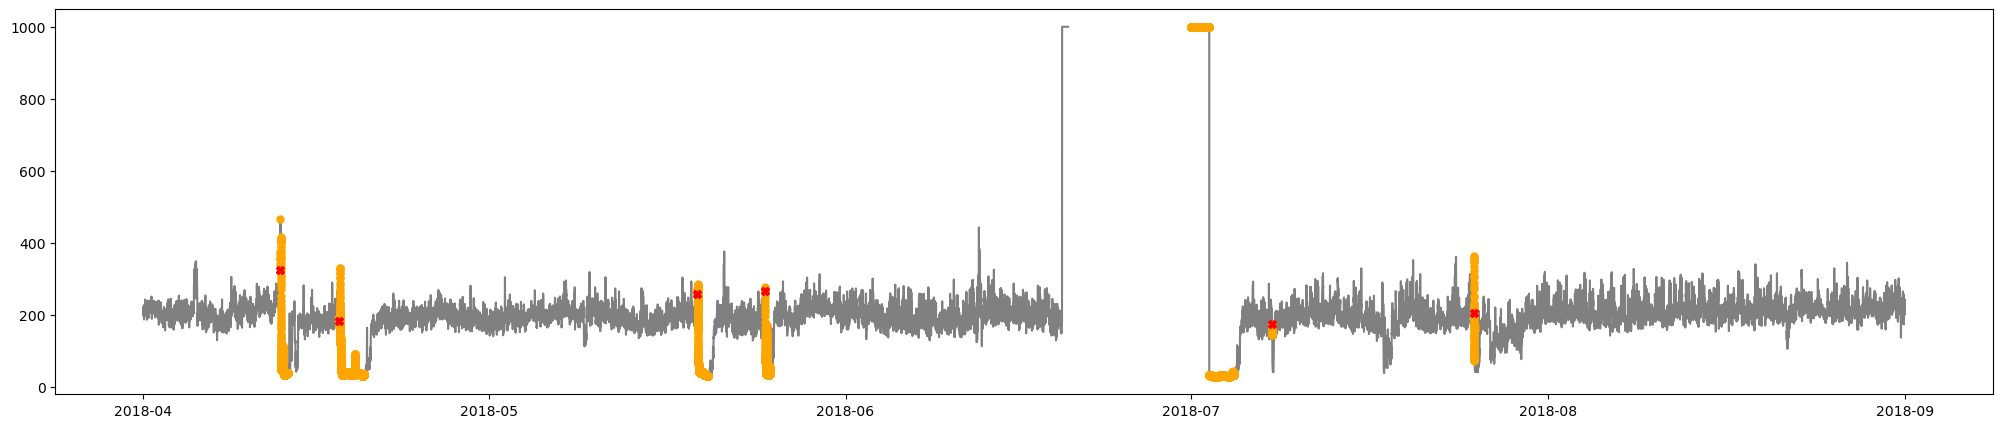

In [48]:
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])
sensor_data.set_index('timestamp', inplace=True)


broken = sensor_data[sensor_data["machine_status"] == 'BROKEN']
recovery = sensor_data[sensor_data["machine_status"] == 'RECOVERING']
normal = sensor_data[sensor_data["machine_status"] == 'NORMAL']


def sensor_plot(sensor):
    fig, ax = plt.subplots(figsize=(25,5))
    ax.plot(sensor_data[sensor], color='grey')
    ax.plot(recovery[sensor], linestyle='none', color='orange', marker='o', markersize=5)
    ax.plot(broken[sensor], linestyle='none', marker='X', color='red')
    plt.show()

sensor_plot('sensor_51')


In [49]:
#filling NA and scaling the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X = sensor_data.iloc[:,:-1]
X = X.fillna(X.mean())
X = scaler.fit_transform(X)

X_train, X_test = X[:-20000], X[-20000:]


In [50]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


outliers_fraction = 1 - (len(normal)/(len(sensor_data))) # where the machine is either broken or recovering. 
isfo = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
loof = LocalOutlierFactor(novelty=True)
ocsv = OneClassSVM()

isfo.fit(X_train)
loof.fit(X_train)
ocsv.fit(X_train)

ypred_isfo = isfo.predict(X)
ypred_loof = loof.predict(X)
ypred_ocsv = ocsv.predict(X)

#from joblib import dump

#dump(isfo, "Isfo_classifier.joblib" )




In [52]:
sensor_data["IsFo"] = ypred_isfo
sensor_data["loof"] = ypred_loof
sensor_data["ocsv"] = ypred_loof

anomaly_isfo = sensor_data[sensor_data['IsFo'] == -1]
anomaly_loof = sensor_data[sensor_data['loof'] == -1]
anomaly_ocsv = sensor_data[sensor_data['ocsv'] == -1]

def sensor_plot_isfo(sensor):
    fig, ax = plt.subplots(figsize=(25,5))
    ax.plot(sensor_data[sensor], color='grey')
    ax.plot(recovery[sensor], linestyle='none', color='orange', marker='o', markersize=5)
    ax.plot(broken[sensor], linestyle='none', marker='X', color='red', markersize=25)
    ax.plot(anomaly_isfo[sensor], linestyle='none', marker = 'X', color = 'blue')
    ax.plot(anomaly_loof[sensor], linestyle='none', marker = '_', color = 'orange')
    ax.plot(anomaly_ocsv[sensor], linestyle='none', marker = 'o', color = 'cyan')
    ax.set_title(sensor)
    plt.show()

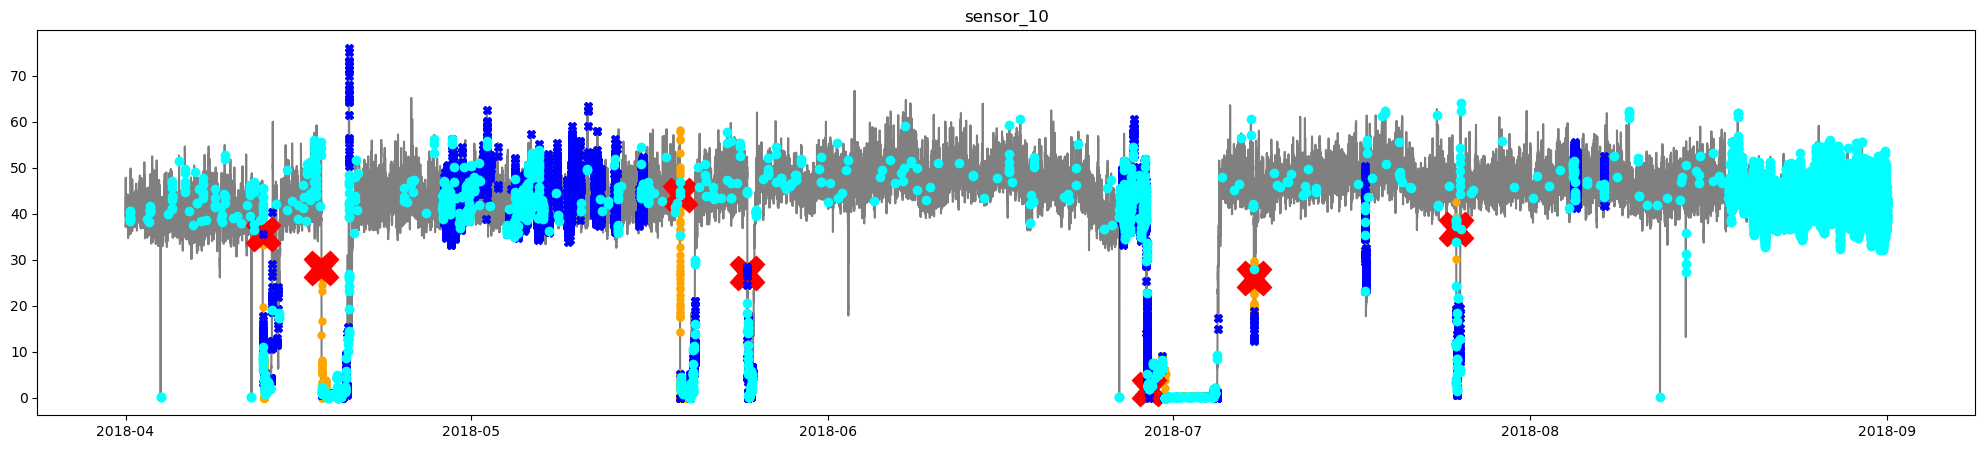

In [53]:
sensor_plot_isfo('sensor_10')